# Multi-Class Classification Deep Learning Model for Faulty Steel Plates Using Keras
### David Lowe
### November 18, 2019

Template Credit: Adapted from a template made available by Dr. Jason Brownlee of Machine Learning Mastery. [https://machinelearningmastery.com/]

SUMMARY: The purpose of this project is to construct a predictive model using various machine learning algorithms and to document the end-to-end steps using a template. The Faulty Steel Plates dataset is a multi-class classification situation where we are trying to predict one of several (more than two) possible outcomes.

INTRODUCTION: This dataset comes from research by Semeion, Research Center of Sciences of Communication. The original aim of the research was to correctly classify the type of surface defects in stainless steel plates, with six types of possible defects (plus "other"). The Input vector was made up of 27 indicators that approximately the geometric shape of the defect and its outline. According to the research paper, Semeion was commissioned by the Centro Sviluppo Materiali (Italy) for this task and therefore it is not possible to provide details on the nature of the 27 indicators used as Input vectors or the types of the 6 classes of defects.

ANALYSIS: The baseline performance of the model achieved an average accuracy score of 72.51%. After tuning the hyperparameters, the best model processed the training dataset with an accuracy of 74.77%. Furthermore, the final model processed the test dataset with an accuracy of 74.28%, which was consistent with the accuracy result from the training data.

CONCLUSION: For this dataset, the model built using Keras and TensorFlow achieved a satisfactory result and should be considered for future modeling activities.

Dataset Used: Steel Plates Faults Dataset

Dataset ML Model: Multi-class classification with numerical attributes

Dataset Reference: http://archive.ics.uci.edu/ml/datasets/steel+plates+faults

One potential source of performance benchmarks: https://www.kaggle.com/uciml/faulty-steel-plates

Any deep-learning modeling project genrally can be broken down into about six major tasks:
0. Prepare Environment
1. Load Data
2. Define Model
3. Fit and Evaluate Model
4. Optimize Model
5. Finalize Model

# Section 0. Prepare Environment

In [1]:
# Set the warning message filter
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
# Set the random seed number for reproducible results
seedNum = 888

In [3]:
# Load libraries and packages
import random
random.seed(seedNum)
import numpy as np
np.random.seed(seedNum)
import tensorflow as tf
tf.random.set_seed(seedNum)
import keras as K
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.wrappers.scikit_learn import KerasRegressor
from keras.utils import np_utils
import pandas as pd
import os
import sys
import shutil
import urllib.request
import zipfile
import smtplib
import matplotlib.pyplot as plt
from datetime import datetime
from email.message import EmailMessage
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn import preprocessing
from sklearn.pipeline import Pipeline

Using TensorFlow backend.


In [4]:
# Begin the timer for the script processing
startTimeScript = datetime.now()

# Set up the verbose flag to print detailed messages for debugging (setting to True will activate)
verbose = True
tf.debugging.set_log_device_placement(verbose)

# Set up the number of CPU cores available for multi-thread processing
n_jobs = -1
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

# Set up the flag to stop sending progress emails (setting to True will send status emails!)
notifyStatus = False

# Set the number of folds for cross validation
n_folds = 5

# Set the flag for splitting the dataset
splitDataset = True
splitPercentage = 0.25

# Set various default Keras modeling parameters
default_kernel_init = K.initializers.RandomNormal(seed=seedNum)
default_loss = 'categorical_crossentropy'
default_optimizer = 'adam'
default_epochs = 500
default_batches = 8
default_metrics = ['accuracy']

Num GPUs Available:  0


In [5]:
# Set up the email notification function
def email_notify(msg_text):
    sender = os.environ.get('MAIL_SENDER')
    receiver = os.environ.get('MAIL_RECEIVER')
    gateway = os.environ.get('SMTP_GATEWAY')
    smtpuser = os.environ.get('SMTP_USERNAME')
    password = os.environ.get('SMTP_PASSWORD')
    if sender==None or receiver==None or gateway==None or smtpuser==None or password==None:
        sys.exit("Incomplete email setup info. Script Processing Aborted!!!")
    msg = EmailMessage()
    msg.set_content(msg_text)
    msg['Subject'] = 'Notification from Keras Multi-Class Classification Script'
    msg['From'] = sender
    msg['To'] = receiver
    server = smtplib.SMTP(gateway, 587)
    server.starttls()
    server.login(smtpuser, password)
    server.send_message(msg)
    server.quit()

In [6]:
if (notifyStatus): email_notify("Phase 0 Prepare Environment completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

# Section 1. Load Data

In [7]:
if (notifyStatus): email_notify("Phase 1 Load Data has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## 1.a) Load Dataset

In [8]:
colNames = []
variable_path = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00198/Faults27x7_var'
variable_list = urllib.request.urlopen(variable_path)
for line in variable_list:
    item = line.decode("utf-8").rstrip("\r\n")
    colNames = colNames + [item]

dataset_path = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00198/Faults.NNA'
Xy_original = pd.read_csv(dataset_path, names=colNames, sep='\t', header=None)

# Take a peek at the dataframe after import
Xy_original.head(10)

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,...,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
0,42,50,270900,270944,267,17,44,24220,76,108,...,0.8182,-0.2913,0.5822,1,0,0,0,0,0,0
1,645,651,2538079,2538108,108,10,30,11397,84,123,...,0.7931,-0.1756,0.2984,1,0,0,0,0,0,0
2,829,835,1553913,1553931,71,8,19,7972,99,125,...,0.6667,-0.1228,0.2150,1,0,0,0,0,0,0
3,853,860,369370,369415,176,13,45,18996,99,126,...,0.8444,-0.1568,0.5212,1,0,0,0,0,0,0
4,1289,1306,498078,498335,2409,60,260,246930,37,126,...,0.9338,-0.1992,1.0000,1,0,0,0,0,0,0
5,430,441,100250,100337,630,20,87,62357,64,127,...,0.8736,-0.2267,0.9874,1,0,0,0,0,0,0
6,413,446,138468,138883,9052,230,432,1481991,23,199,...,0.9205,0.2791,1.0000,1,0,0,0,0,0,0
7,190,200,210936,210956,132,11,20,20007,124,172,...,0.5000,0.1841,0.3359,1,0,0,0,0,0,0
8,330,343,429227,429253,264,15,26,29748,53,148,...,0.5000,-0.1197,0.5593,1,0,0,0,0,0,0
9,74,90,779144,779308,1506,46,167,180215,53,143,...,0.9024,-0.0651,1.0000,1,0,0,0,0,0,0


In [9]:
Xy_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1941 entries, 0 to 1940
Data columns (total 34 columns):
X_Minimum                1941 non-null int64
X_Maximum                1941 non-null int64
Y_Minimum                1941 non-null int64
Y_Maximum                1941 non-null int64
Pixels_Areas             1941 non-null int64
X_Perimeter              1941 non-null int64
Y_Perimeter              1941 non-null int64
Sum_of_Luminosity        1941 non-null int64
Minimum_of_Luminosity    1941 non-null int64
Maximum_of_Luminosity    1941 non-null int64
Length_of_Conveyer       1941 non-null int64
TypeOfSteel_A300         1941 non-null int64
TypeOfSteel_A400         1941 non-null int64
Steel_Plate_Thickness    1941 non-null int64
Edges_Index              1941 non-null float64
Empty_Index              1941 non-null float64
Square_Index             1941 non-null float64
Outside_X_Index          1941 non-null float64
Edges_X_Index            1941 non-null float64
Edges_Y_Index            194

In [10]:
Xy_original.describe()

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,...,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
count,1941.000000,1941.000000,1.941000e+03,1.941000e+03,1941.000000,1941.000000,1941.000000,1.941000e+03,1941.000000,1941.000000,...,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000
mean,571.136012,617.964451,1.650685e+06,1.650739e+06,1893.878413,111.855229,82.965997,2.063121e+05,84.548686,130.193715,...,0.083288,-0.131305,0.585420,0.081401,0.097888,0.201443,0.037094,0.028336,0.207110,0.346728
std,520.690671,497.627410,1.774578e+06,1.774590e+06,5168.459560,301.209187,426.482879,5.122936e+05,32.134276,18.690992,...,0.500868,0.148767,0.339452,0.273521,0.297239,0.401181,0.189042,0.165973,0.405339,0.476051
min,0.000000,4.000000,6.712000e+03,6.724000e+03,2.000000,2.000000,1.000000,2.500000e+02,0.000000,37.000000,...,-0.991000,-0.998900,0.119000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,51.000000,192.000000,4.712530e+05,4.712810e+05,84.000000,15.000000,13.000000,9.522000e+03,63.000000,124.000000,...,-0.333300,-0.195000,0.248200,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,435.000000,467.000000,1.204128e+06,1.204136e+06,174.000000,26.000000,25.000000,1.920200e+04,90.000000,127.000000,...,0.095200,-0.133000,0.506300,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1053.000000,1072.000000,2.183073e+06,2.183084e+06,822.000000,84.000000,83.000000,8.301100e+04,106.000000,140.000000,...,0.511600,-0.066600,0.999800,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1705.000000,1713.000000,1.298766e+07,1.298769e+07,152655.000000,10449.000000,18152.000000,1.159141e+07,203.000000,253.000000,...,0.991700,0.642100,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [11]:
print(Xy_original.isnull().sum())
print('Total number of NaN in the dataframe: ', Xy_original.isnull().sum().sum())

X_Minimum                0
X_Maximum                0
Y_Minimum                0
Y_Maximum                0
Pixels_Areas             0
X_Perimeter              0
Y_Perimeter              0
Sum_of_Luminosity        0
Minimum_of_Luminosity    0
Maximum_of_Luminosity    0
Length_of_Conveyer       0
TypeOfSteel_A300         0
TypeOfSteel_A400         0
Steel_Plate_Thickness    0
Edges_Index              0
Empty_Index              0
Square_Index             0
Outside_X_Index          0
Edges_X_Index            0
Edges_Y_Index            0
Outside_Global_Index     0
LogOfAreas               0
Log_X_Index              0
Log_Y_Index              0
Orientation_Index        0
Luminosity_Index         0
SigmoidOfAreas           0
Pastry                   0
Z_Scratch                0
K_Scatch                 0
Stains                   0
Dirtiness                0
Bumps                    0
Other_Faults             0
dtype: int64
Total number of NaN in the dataframe:  0


## 1.b) Data Cleaning

In [12]:
y_onehot = Xy_original.loc[:,'Pastry':'Other_Faults']
Xy_original['targetVar'] = y_onehot.idxmax(axis=1)
Xy_original.drop(columns=['Pastry','Z_Scratch','K_Scatch','Stains','Dirtiness','Bumps','Other_Faults'], inplace=True)

# Take a peek at the dataframe after cleaning
print(Xy_original.head(-10))

      X_Minimum  X_Maximum  Y_Minimum  Y_Maximum  Pixels_Areas  X_Perimeter  \
0            42         50     270900     270944           267           17   
1           645        651    2538079    2538108           108           10   
2           829        835    1553913    1553931            71            8   
3           853        860     369370     369415           176           13   
4          1289       1306     498078     498335          2409           60   
...         ...        ...        ...        ...           ...          ...   
1926       1053       1063     173208     173226            68           26   
1927        160        170     252936     252958            97           24   
1928       1303       1344      33298      33323           452           44   
1929        130        153     197701     197718           240           47   
1930        247        272     244048     244067           235           36   

      Y_Perimeter  Sum_of_Luminosity  Minimum_of_Lu

In [13]:
Xy_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1941 entries, 0 to 1940
Data columns (total 28 columns):
X_Minimum                1941 non-null int64
X_Maximum                1941 non-null int64
Y_Minimum                1941 non-null int64
Y_Maximum                1941 non-null int64
Pixels_Areas             1941 non-null int64
X_Perimeter              1941 non-null int64
Y_Perimeter              1941 non-null int64
Sum_of_Luminosity        1941 non-null int64
Minimum_of_Luminosity    1941 non-null int64
Maximum_of_Luminosity    1941 non-null int64
Length_of_Conveyer       1941 non-null int64
TypeOfSteel_A300         1941 non-null int64
TypeOfSteel_A400         1941 non-null int64
Steel_Plate_Thickness    1941 non-null int64
Edges_Index              1941 non-null float64
Empty_Index              1941 non-null float64
Square_Index             1941 non-null float64
Outside_X_Index          1941 non-null float64
Edges_X_Index            1941 non-null float64
Edges_Y_Index            194

In [14]:
Xy_original.describe()

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,...,Outside_X_Index,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas
count,1941.000000,1941.000000,1.941000e+03,1.941000e+03,1941.000000,1941.000000,1941.000000,1.941000e+03,1941.000000,1941.000000,...,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000
mean,571.136012,617.964451,1.650685e+06,1.650739e+06,1893.878413,111.855229,82.965997,2.063121e+05,84.548686,130.193715,...,0.033361,0.610529,0.813472,0.575734,2.492388,1.335686,1.403271,0.083288,-0.131305,0.585420
std,520.690671,497.627410,1.774578e+06,1.774590e+06,5168.459560,301.209187,426.482879,5.122936e+05,32.134276,18.690992,...,0.058961,0.243277,0.234274,0.482352,0.788930,0.481612,0.454345,0.500868,0.148767,0.339452
min,0.000000,4.000000,6.712000e+03,6.724000e+03,2.000000,2.000000,1.000000,2.500000e+02,0.000000,37.000000,...,0.001500,0.014400,0.048400,0.000000,0.301000,0.301000,0.000000,-0.991000,-0.998900,0.119000
25%,51.000000,192.000000,4.712530e+05,4.712810e+05,84.000000,15.000000,13.000000,9.522000e+03,63.000000,124.000000,...,0.006600,0.411800,0.596800,0.000000,1.924300,1.000000,1.079200,-0.333300,-0.195000,0.248200
50%,435.000000,467.000000,1.204128e+06,1.204136e+06,174.000000,26.000000,25.000000,1.920200e+04,90.000000,127.000000,...,0.010100,0.636400,0.947400,1.000000,2.240600,1.176100,1.322200,0.095200,-0.133000,0.506300
75%,1053.000000,1072.000000,2.183073e+06,2.183084e+06,822.000000,84.000000,83.000000,8.301100e+04,106.000000,140.000000,...,0.023500,0.800000,1.000000,1.000000,2.914900,1.518500,1.732400,0.511600,-0.066600,0.999800
max,1705.000000,1713.000000,1.298766e+07,1.298769e+07,152655.000000,10449.000000,18152.000000,1.159141e+07,203.000000,253.000000,...,0.875900,1.000000,1.000000,1.000000,5.183700,3.074100,4.258700,0.991700,0.642100,1.000000


In [15]:
print(Xy_original.isnull().sum())
print('Total number of NaN in the dataframe: ', Xy_original.isnull().sum().sum())

X_Minimum                0
X_Maximum                0
Y_Minimum                0
Y_Maximum                0
Pixels_Areas             0
X_Perimeter              0
Y_Perimeter              0
Sum_of_Luminosity        0
Minimum_of_Luminosity    0
Maximum_of_Luminosity    0
Length_of_Conveyer       0
TypeOfSteel_A300         0
TypeOfSteel_A400         0
Steel_Plate_Thickness    0
Edges_Index              0
Empty_Index              0
Square_Index             0
Outside_X_Index          0
Edges_X_Index            0
Edges_Y_Index            0
Outside_Global_Index     0
LogOfAreas               0
Log_X_Index              0
Log_Y_Index              0
Orientation_Index        0
Luminosity_Index         0
SigmoidOfAreas           0
targetVar                0
dtype: int64
Total number of NaN in the dataframe:  0


## 1.c) Feature Scaling and Pre-processing

In [16]:
# Use variable totCol to hold the number of columns in the dataframe
totCol = len(Xy_original.columns)

# Set up variable totAttr for the total number of attribute columns
totAttr = totCol-1

# targetCol variable indicates the column location of the target/class variable
# If the first column, set targetCol to 1. If the last column, set targetCol to totCol
# If (targetCol <> 1) and (targetCol <> totCol), be aware when slicing up the dataframes for visualization
targetCol = totCol

In [17]:
# We create attribute-only and target-only datasets (X_original and y_original)
# for various visualization and cleaning/transformation operations

if targetCol == totCol:
    X_original = Xy_original.iloc[:,0:totAttr]
    y_original = Xy_original.iloc[:,totAttr]
else:
    X_original = Xy_original.iloc[:,1:totCol]
    y_original = Xy_original.iloc[:,0]

print("Xy_original.shape: {} X_original.shape: {} y_original.shape: {}".format(Xy_original.shape, X_original.shape, y_original.shape))

Xy_original.shape: (1941, 28) X_original.shape: (1941, 27) y_original.shape: (1941,)


In [18]:
# Set up the number of row and columns for visualization display. dispRow * dispCol should be >= totAttr
dispCol = 4
if totAttr % dispCol == 0 :
    dispRow = totAttr // dispCol
else :
    dispRow = (totAttr // dispCol) + 1
    
# Set figure width to display the data visualization plots
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = dispCol*4
fig_size[1] = dispRow*4
plt.rcParams["figure.figsize"] = fig_size

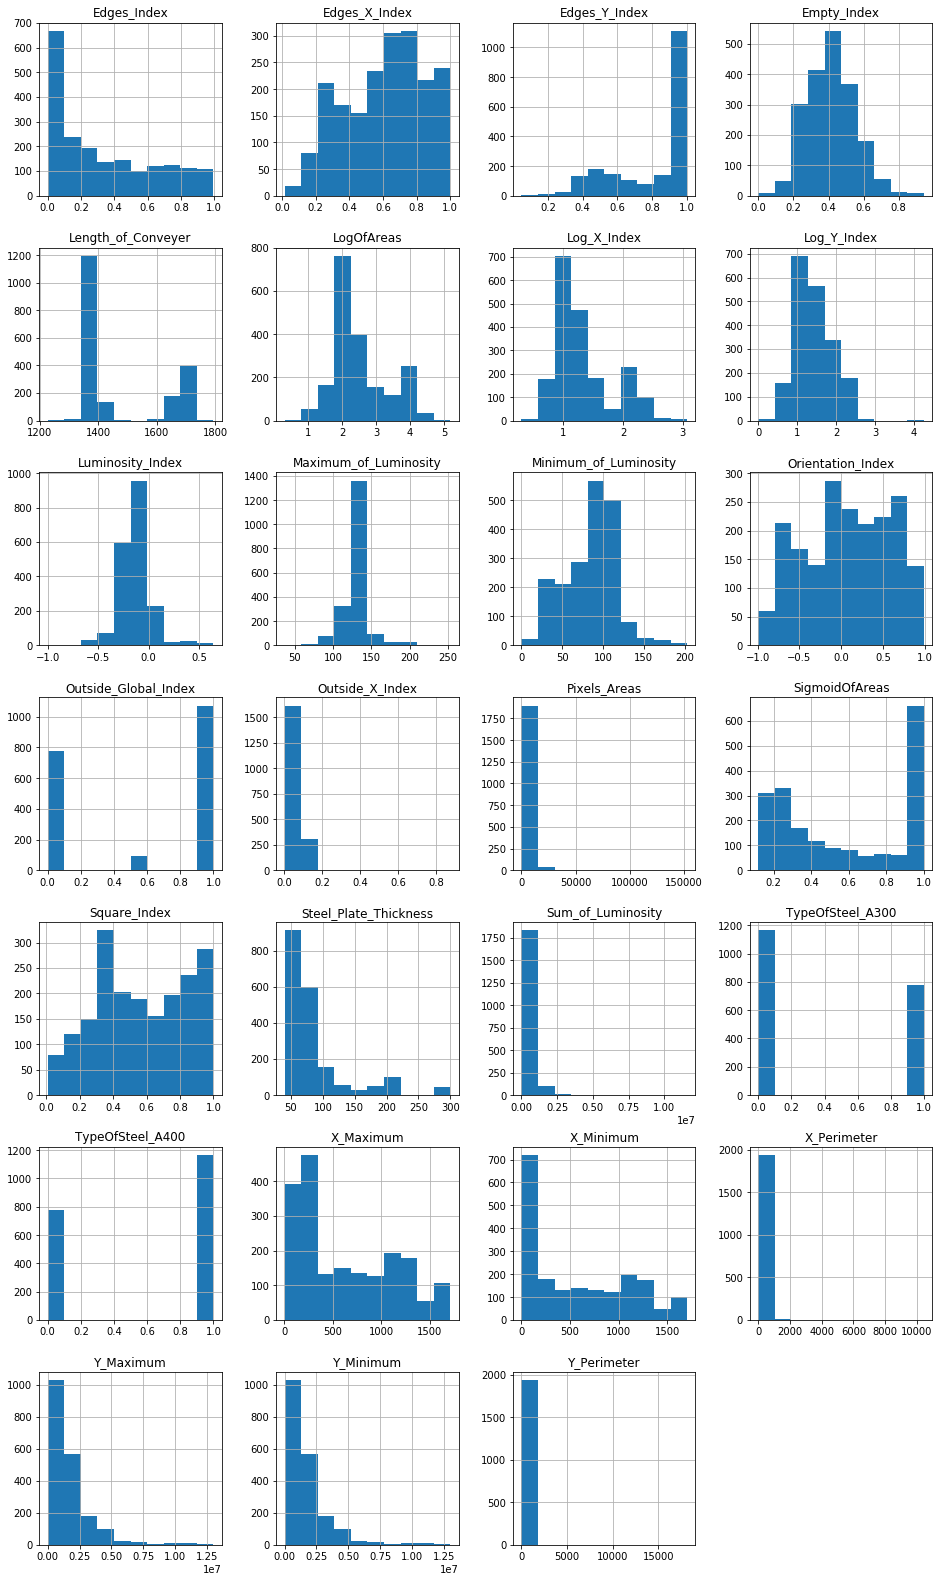

In [19]:
# Histograms for each attribute before pre-processing
X_original.hist(layout=(dispRow,dispCol))
plt.show()

In [20]:
# Apply feature scaling and transformation
X_original = X_original.astype(float)
# X_original['some_feature'] = preprocessing.scale(X_original['some_feature'])
preprocessing.scale(X_original, copy=False)
# X_original['some_feature'] = preprocessing.normalize(X_original['some_feature'])
# preprocessing.normalize(X_original, copy=False)
print(X_original.head(-10))

      X_Minimum  X_Maximum  Y_Minimum  Y_Maximum  Pixels_Areas  X_Perimeter  \
0     -1.016481  -1.141639  -0.777729  -0.777729     -0.314852    -0.314996   
1      0.141894   0.066403   0.500188   0.500171     -0.345623    -0.338242   
2      0.495362   0.436253  -0.054546  -0.054566     -0.352784    -0.344883   
3      0.541467   0.486504  -0.722225  -0.722225     -0.332463    -0.328279   
4      1.379032   1.382988  -0.649678  -0.649559      0.099692    -0.172201   
...         ...        ...        ...        ...           ...          ...   
1926   0.925671   0.894545  -0.832794  -0.832808     -0.353364    -0.285109   
1927  -0.789801  -0.900432  -0.787854  -0.787867     -0.347752    -0.291750   
1928   1.405926   1.459370  -0.911655  -0.911665     -0.279048    -0.225334   
1929  -0.847432  -0.934603  -0.818988  -0.819003     -0.320077    -0.215372   
1930  -0.622672  -0.695407  -0.792864  -0.792878     -0.321045    -0.251901   

      Y_Perimeter  Sum_of_Luminosity  Minimum_of_Lu

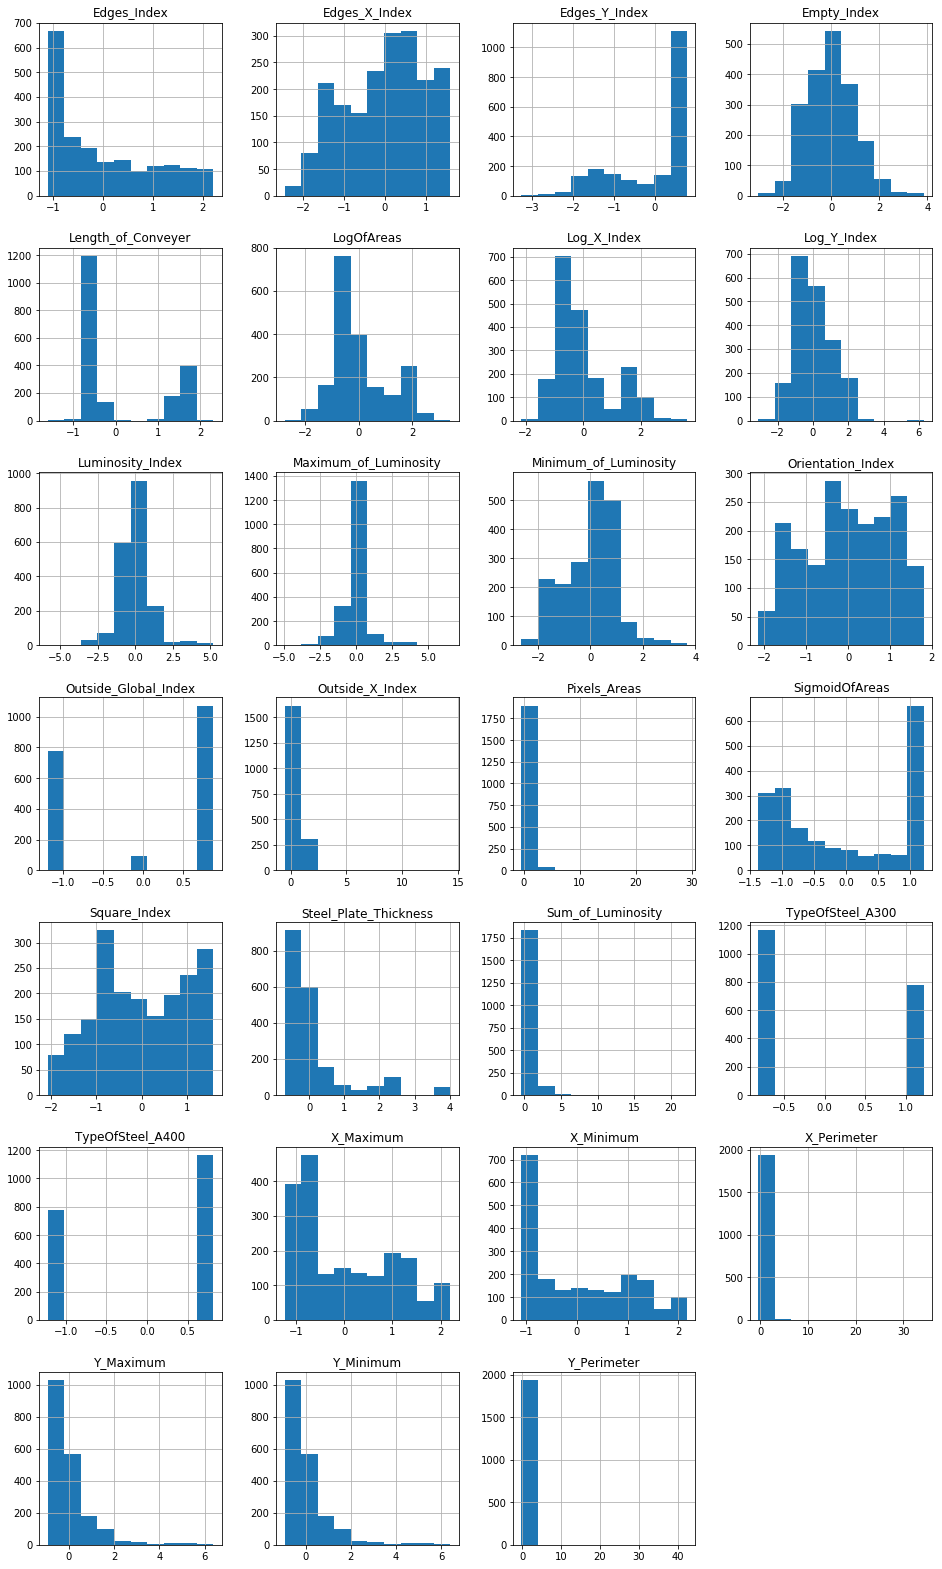

In [21]:
# Histograms for each attribute after pre-processing
X_original.hist(layout=(dispRow,dispCol))
plt.show()

In [22]:
# Perform one-hot-encoding before splitting into trainig and test
# X_original = pd.get_dummies(X_original)
# print(X_original.info())

## 1.d) Splitting Data into Training and Test Sets

In [23]:
# Encode class values as integers and perform one-hot-encoding
encoder = preprocessing.LabelEncoder()
encoder.fit(y_original)
y_transformed = encoder.transform(y_original)
y_encoded = np_utils.to_categorical(y_transformed)
print(y_encoded)

[[0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [24]:
X_encoded = X_original.values
if (splitDataset):
    X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_encoded, test_size=splitPercentage, random_state=seedNum)
else:
    X_train, y_train = X_encoded, y_encoded
    X_test, y_test = X_encoded, y_encoded
print("X_train.shape: {} X_train.type: {}".format(X_train.shape, type(X_train)))
print("y_train.shape: {} y_train.type: {}".format(y_train.shape, type(y_train)))
print("X_test.shape: {} X_test.type: {}".format(X_test.shape, type(X_test)))
print("y_test.shape: {} y_test.type: {}".format(y_test.shape, type(y_test)))

X_train.shape: (1455, 27) X_train.type: <class 'numpy.ndarray'>
y_train.shape: (1455, 7) y_train.type: <class 'numpy.ndarray'>
X_test.shape: (486, 27) X_test.type: <class 'numpy.ndarray'>
y_test.shape: (486, 7) y_test.type: <class 'numpy.ndarray'>


In [25]:
if (notifyStatus): email_notify("Phase 1 Load Data completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

# Section 2. Define Model

In [26]:
if (notifyStatus): email_notify("Phase 2 Define Model has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [27]:
# Define the Keras model required for KerasClassifier
def create_default_model():
    default_model = K.models.Sequential()
    default_model.add(Dense(60, input_dim=27, kernel_initializer=default_kernel_init, activation='relu'))
    default_model.add(Dense(40, kernel_initializer=default_kernel_init, activation='relu'))
    default_model.add(Dense(20, kernel_initializer=default_kernel_init, activation='relu'))
    default_model.add(Dense(7, kernel_initializer=default_kernel_init, activation='softmax'))
    default_model.compile(loss=default_loss, optimizer=default_optimizer, metrics=default_metrics)
    return default_model

In [28]:
# Initialize the Keras model
cv_model = KerasClassifier(build_fn=create_default_model, epochs=default_epochs, batch_size=default_batches, verbose=0)

In [29]:
if (notifyStatus): email_notify("Phase 2 Define Model completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

# Section 3. Fit and Evaluate Model

In [30]:
if (notifyStatus): email_notify("Phase 3 Fit and Evaluate Model has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [31]:
startTimeModule = datetime.now()

# Fit and evaluate the Keras model using n-fold cross validation
kfold = KFold(n_splits=n_folds, shuffle=True, random_state=seedNum)
results = cross_val_score(cv_model, X_train, y_train, cv=kfold)
print('Generating results using the metrics of', default_metrics)
print('All cross-Validate results:', results)
print('Baseline results [mean (std)]: %.2f%% (%.2f%%)' % (results.mean()*100, results.std()*100))

print('Total time for performing cross-validation of the default model:', (datetime.now() - startTimeModule))

Executing op RandomStandardNormal in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RandomStandardNormal in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job

In [32]:
if (notifyStatus): email_notify("Phase 3 Fit and Evaluate Model completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

# Section 4. Optimize Model

In [33]:
if (notifyStatus): email_notify("Phase 4 Optimize Model has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [34]:
# Define the Keras model required for KerasClassifier
def create_customized_model(optimizer, kernel_init):
    customized_model = K.models.Sequential()
    customized_model.add(Dense(60, input_dim=27, kernel_initializer=kernel_init, activation='relu'))
    customized_model.add(Dense(40, kernel_initializer=default_kernel_init, activation='relu'))
    customized_model.add(Dense(20, kernel_initializer=default_kernel_init, activation='relu'))
    customized_model.add(Dense(7, kernel_initializer=kernel_init, activation='softmax'))
    customized_model.compile(loss=default_loss, optimizer=optimizer, metrics=default_metrics)
    return customized_model

In [35]:
startTimeModule = datetime.now()

# create model
grid_model = KerasClassifier(build_fn=create_customized_model, verbose=0)

# Perform grid search using different epochs, batch sizes, and optimizers
optz_1 = K.optimizers.Adam(learning_rate=0.001)
optz_2 = K.optimizers.Adam(learning_rate=0.005)
optz_3 = K.optimizers.Adam(learning_rate=0.009)
optimizer_grid = [optz_1, optz_2, optz_3]
init_1 = K.initializers.RandomNormal(seed=seedNum)
init_2 = K.initializers.glorot_normal(seed=seedNum)
init_3 = K.initializers.Orthogonal(seed=seedNum)
init_grid = [init_1, init_2, init_3]
epoch_grid = [500, 750, 1000]
batch_grid = [8, 16, 32]
param_grid = dict(optimizer=optimizer_grid, kernel_init=init_grid, epochs=epoch_grid, batch_size=batch_grid)
# grid = GridSearchCV(estimator=grid_model, param_grid=param_grid, cv=n_folds, n_jobs=n_jobs, verbose=3)
n_iter = int(len(optimizer_grid) * len(init_grid) * len(epoch_grid) * len(batch_grid) * 0.33)
grid = RandomizedSearchCV(estimator=grid_model, param_distributions=param_grid, n_iter=n_iter, cv=n_folds, n_jobs=n_jobs, verbose=3)
grid_result = grid.fit(X_train, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) with: %r" % (mean, stdev, param))

print('Total time for performing grid-search of the best parameters:', (datetime.now() - startTimeModule))

Fitting 5 folds for each of 26 candidates, totalling 130 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0


[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed: 59.9min


Executing op TruncatedNormal in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RandomStandardNormal in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RandomStandardNormal in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TruncatedNormal in device /job:localhost/replica:0/task:0/device:CPU:0


[Parallel(n_jobs=-1)]: Done 130 out of 130 | elapsed: 68.4min finished


Executing op __inference_keras_scratch_graph_1839167 in device /job:localhost/replica:0/task:0/device:CPU:0
Best: 0.747766 using {'optimizer': <keras.optimizers.Adam object at 0x7f47d5f3b510>, 'kernel_init': <keras.initializers.VarianceScaling object at 0x7f47d5f3bf50>, 'epochs': 1000, 'batch_size': 16}
0.731959 (0.027918) with: {'optimizer': <keras.optimizers.Adam object at 0x7f47d5f3b550>, 'kernel_init': <keras.initializers.VarianceScaling object at 0x7f47d5f3bf50>, 'epochs': 500, 'batch_size': 32}
0.720962 (0.032557) with: {'optimizer': <keras.optimizers.Adam object at 0x7f47d5f3b550>, 'kernel_init': <keras.initializers.RandomNormal object at 0x7f47d5f3bd90>, 'epochs': 1000, 'batch_size': 8}
0.744330 (0.012784) with: {'optimizer': <keras.optimizers.Adam object at 0x7f47d5f3b510>, 'kernel_init': <keras.initializers.VarianceScaling object at 0x7f47d5f3bf50>, 'epochs': 750, 'batch_size': 16}
0.737457 (0.015912) with: {'optimizer': <keras.optimizers.Adam object at 0x7f47d5f3b550>, 'kern

In [36]:
best_optimizer = grid_result.best_params_["optimizer"]
best_kernel_init = grid_result.best_params_["kernel_init"]
best_epoch = grid_result.best_params_["epochs"]
best_batch = grid_result.best_params_["batch_size"]

In [37]:
# Create the final model for evaluating the test dataset
print('Forming the final model using: optimizer=%s, kernel=%s, epochs=%d, batch_size=%d'
      % (best_optimizer, best_kernel_init, best_epoch, best_batch))
final_model = create_customized_model(best_optimizer, best_kernel_init)
final_model.fit(X_train, y_train, epochs=best_epoch, batch_size=best_batch, verbose=0)

Forming the final model using: optimizer=<keras.optimizers.Adam object at 0x7f47d5f3b510>, kernel=<keras.initializers.VarianceScaling object at 0x7f47d5f3bf50>, epochs=1000, batch_size=16
Executing op TruncatedNormal in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RandomStandardNormal in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RandomStandardNormal in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TruncatedNormal in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_keras_scratch_graph_2297303 in device /job:localhost/replica:0/task:0/device:CPU:0


In [38]:
# Display a summary of the final model
print(final_model.summary())

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 60)                1680      
_________________________________________________________________
dense_26 (Dense)             (None, 40)                2440      
_________________________________________________________________
dense_27 (Dense)             (None, 20)                820       
_________________________________________________________________
dense_28 (Dense)             (None, 7)                 147       
Total params: 5,087
Trainable params: 5,087
Non-trainable params: 0
_________________________________________________________________
None


In [39]:
# Display the configuration of the final model
print(final_model.get_config())

{'name': 'sequential_7', 'layers': [{'class_name': 'Dense', 'config': {'name': 'dense_25', 'trainable': True, 'batch_input_shape': (None, 27), 'dtype': 'float32', 'units': 60, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'normal', 'seed': 892}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}}, {'class_name': 'Dense', 'config': {'name': 'dense_26', 'trainable': True, 'dtype': 'float32', 'units': 40, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'class_name': 'RandomNormal', 'config': {'mean': 0.0, 'stddev': 0.05, 'seed': 912}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': No

In [40]:
# Evaluate the Keras model on previously unseen data
scores = final_model.evaluate(X_test, y_test)
print("\n%s: %.2f%%" % (final_model.metrics_names[1], scores[1]*100))
print("\n%s: %.2f" % (final_model.metrics_names[0], scores[0]))

Executing op __inference_keras_scratch_graph_2754395 in device /job:localhost/replica:0/task:0/device:CPU:0
486/486 [==============================] - 0s 209us/step

accuracy: 74.28%

loss: 3.89


In [41]:
if (notifyStatus): email_notify("Phase 4 Optimize Model completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

# Section 5. Finalize Model

In [42]:
if (notifyStatus): email_notify("Phase 5 Finalize Model has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [43]:
# Make class predictions with the model
predictions = final_model.predict_classes(X_test)

# Summarize the first 20 cases
for i in range(20):
	print('Data item #%d predicted to be %s (expected %s)' % (i, encoder.inverse_transform([predictions[i]]), encoder.inverse_transform([np.argmax(y_test[i])])))

Executing op __inference_keras_scratch_graph_2754509 in device /job:localhost/replica:0/task:0/device:CPU:0
Data item #0 predicted to be ['K_Scatch'] (expected ['Bumps'])
Data item #1 predicted to be ['Other_Faults'] (expected ['Bumps'])
Data item #2 predicted to be ['Dirtiness'] (expected ['Dirtiness'])
Data item #3 predicted to be ['Z_Scratch'] (expected ['Z_Scratch'])
Data item #4 predicted to be ['K_Scatch'] (expected ['K_Scatch'])
Data item #5 predicted to be ['Z_Scratch'] (expected ['Z_Scratch'])
Data item #6 predicted to be ['Other_Faults'] (expected ['Other_Faults'])
Data item #7 predicted to be ['Pastry'] (expected ['Pastry'])
Data item #8 predicted to be ['Pastry'] (expected ['Pastry'])
Data item #9 predicted to be ['Other_Faults'] (expected ['Pastry'])
Data item #10 predicted to be ['Other_Faults'] (expected ['Pastry'])
Data item #11 predicted to be ['K_Scatch'] (expected ['K_Scatch'])
Data item #12 predicted to be ['Pastry'] (expected ['Pastry'])
Data item #13 predicted to 

In [44]:
if (notifyStatus): email_notify("Phase 5 Finalize Model completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [45]:
print ('Total time for the script:',(datetime.now() - startTimeScript))

Total time for the script: 1:32:44.318642
